In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


# 检查GPU是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import (
    SubsetRandomSampler,
)  # <<< UPDATED: 用于 train/val 划分
import numpy as np  # <<< UPDATED
import os

# 1. 训练集：数据增强 + 标准化
train_transform = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(
            # brightness=0.2 对应的范围为 [0.8, 1.2]，此处显式给出范围
            brightness=(0.8, 1.2),  # <<< UPDATED
            contrast=(0.8, 1.2),  # <<< UPDATED
            saturation=(0.8, 1.2),  # <<< UPDATED
            hue=(-0.05, 0.05),  # <<< UPDATED: 使用较小范围控制色调变化幅度
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(
                0.4914,
                0.4822,
                0.4465,
            ),  # <<< UPDATED: 使用 CIFAR-10 训练集的通道均值
            std=(
                0.2470,
                0.2435,
                0.2616,
            ),  # <<< UPDATED: 使用 CIFAR-10 训练集的通道标准差
        ),
    ]
)

# 2. 测试集（以及验证集）仅执行 ToTensor + Normalize
test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.4914, 0.4822, 0.4465),  # <<< UPDATED
            std=(0.2470, 0.2435, 0.2616),
        ),
    ]
)

# TODO validation dataset 调参,lr,lr scheduler,early stopping
# <<< UPDATED: 在训练集中划分一部分作为验证集

full_train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=train_transform
)

val_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=False, transform=test_transform
)  # <<< UPDATED: 验证集使用无增强的数据预处理流程

num_train = len(full_train_dataset)
indices = list(range(num_train))
val_ratio = 0.1
split = int(np.floor(val_ratio * num_train))

np.random.seed(42)  # <<< UPDATED: 固定随机种子保证划分可复现
np.random.shuffle(indices)

val_idx = indices[:split]
train_idx = indices[split:]

train_sampler = SubsetRandomSampler(train_idx)  # <<< UPDATED
val_sampler = SubsetRandomSampler(val_idx)  # <<< UPDATED

# 3. 测试集
testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=test_transform
)

# 4. DataLoader：按系统 CPU 数量限制 num_workers
num_workers = min(2, (os.cpu_count() or 2) // 2)

trainloader = DataLoader(
    full_train_dataset, batch_size=64, sampler=train_sampler, num_workers=num_workers
)

valloader = DataLoader(
    val_dataset, batch_size=64, sampler=val_sampler, num_workers=num_workers
)  # <<< UPDATED: 验证集 DataLoader

testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=num_workers)

classes = [
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

print("训练样本数:", len(train_idx))
print("验证样本数:", len(val_idx))  # <<< UPDATED
print("测试样本数:", len(testset))

Files already downloaded and verified
Files already downloaded and verified
训练样本数: 45000
验证样本数: 5000
测试样本数: 10000


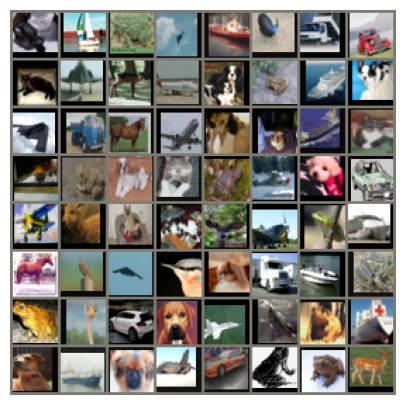

Labels: ['cat', 'ship', 'frog', 'plane', 'ship', 'bird', 'truck', 'car', 'cat', 'plane', 'deer', 'plane', 'dog', 'frog', 'ship', 'dog', 'plane', 'truck', 'horse', 'plane', 'cat', 'cat', 'ship', 'cat', 'cat', 'frog', 'dog', 'cat', 'frog', 'plane', 'dog', 'car', 'plane', 'deer', 'dog', 'cat', 'deer', 'plane', 'frog', 'ship', 'horse', 'bird', 'plane', 'bird', 'dog', 'truck', 'ship', 'frog', 'frog', 'bird', 'car', 'dog', 'plane', 'plane', 'frog', 'ship', 'dog', 'ship', 'dog', 'plane', 'car', 'frog', 'frog', 'deer']


In [3]:
# 可视化部分增强后的样本，用于检查图像与标签的对应关系

import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision

# CIFAR-10 的 mean 和 std
mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
std = torch.tensor([0.2470, 0.2435, 0.2616]).view(3, 1, 1)


def imshow(img, title=None, denorm=True):
    """img: [C,H,W] 或 [B,C,H,W] 做成 grid 后的 Tensor"""
    if denorm:
        img = img * std + mean  # 反标准化
    img = img.clamp(0.0, 1.0)

    img = img.permute(1, 2, 0).cpu().numpy()
    plt.imshow(img)
    plt.axis("off")
    if title is not None:
        plt.title(title)


# ---- 展示一批图 ----
dataiter = iter(trainloader)
images, labels = next(dataiter)

grid = torchvision.utils.make_grid(images, nrow=8)

plt.figure(figsize=(10, 5))
imshow(grid)
plt.show()

print("Labels:", [classes[l] for l in labels])

In [4]:
# LeNet 模型，在 CIFAR-10 上做分类的简单 CNN
#
# TODO 1: transfer learning — 作为基线模型，可与基于预训练权重的网络（AlexNet / VGG / ResNet）进行性能对比。
# TODO 2: parameters / hyperparameters — 在训练脚本中显式记录模型参数量、训练超参数等信息，便于实验对照与分析。

import torch.nn as nn


class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        # -------------------------------------------
        # 卷积特征提取部分（Feature Extraction）
        # 两层卷积 + ReLU + 池化，用于学习视觉特征
        # -------------------------------------------
        self.cnn = nn.Sequential(
            # 输入: [B, 3, 32, 32]
            # Conv1: 3 → 6, kernel 5×5 → 输出 [B, 6, 28, 28]
            nn.Conv2d(3, 6, kernel_size=5),
            nn.ReLU(),
            # 池化后尺寸变为 [B, 6, 14, 14]
            nn.AvgPool2d(2, 2),
            # Conv2: 6 → 16, kernel 5×5 → 输出 [B, 16, 10, 10]
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            # 池化后尺寸变为 [B, 16, 5, 5]
            nn.AvgPool2d(2, 2),
        )

        # -------------------------------------------
        # 全连接分类部分（Classifier）
        # 将卷积特征展平并映射到 10 类
        # -------------------------------------------
        #
        # 可学习参数（parameters）：Conv/Linear 的权重与偏置，在训练中更新。
        # 超参数（hyperparameters）：通道数、kernel_size、隐藏维度、激活函数等，由代码显式定义。
        #
        self.fc = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),  # 400 → 120
            nn.ReLU(),
            nn.Linear(120, 84),  # 120 → 84
            nn.ReLU(),
            nn.Linear(84, 10),  # 84 → 10 类
        )

        """
        数据流示意：
        输入: [B, 3, 32, 32]

        Conv1 → ReLU → Pool:
            [B, 3, 32, 32] → [B, 6, 28, 28] → [B, 6, 14, 14]

        Conv2 → ReLU → Pool:
            [B, 6, 14, 14] → [B, 16, 10, 10] → [B, 16, 5, 5]

        展平:
            [B, 400]

        全连接层:
            [B, 400] → [B, 10]
        """

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# 用于统计可学习参数数量，便于参数量对比或实验记录
def count_learnable_params(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
# 用交叉熵 + Adam 在 CIFAR-10 上训练 LeNet，并记录每个 epoch 的训练损失

# 1. 定义模型实例
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device)

# 2. 定义损失函数与优化器
criterion = nn.CrossEntropyLoss()  # 多分类交叉熵

optimizer = optim.Adam(model.parameters(), lr=0.001)  # lr = learning rate

# 训练与验证损失记录
train_loss_per_epoch = []  # <<< UPDATED: 记录 epoch 级训练损失
val_loss_per_epoch = []  # <<< UPDATED: 记录 epoch 级验证损失

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # ----------------------
    # 训练阶段
    # ----------------------
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # 平均训练损失（epoch）
    epoch_train_loss = running_loss / len(trainloader)
    train_loss_per_epoch.append(epoch_train_loss)  # <<< UPDATED

    # ----------------------
    # 验证阶段
    # ----------------------
    model.eval()
    val_running_loss = 0.0

    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

    epoch_val_loss = val_running_loss / len(valloader)
    val_loss_per_epoch.append(epoch_val_loss)  # <<< UPDATED

    # ----------------------
    # epoch 损失输出（train + validation）
    # ----------------------
    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Train Loss: {epoch_train_loss:.4f} | "
        f"Val Loss: {epoch_val_loss:.4f}"
    )

# TODO epoch的loss记录，论文要提供epoch loss和validation loss
# <<< UPDATED: train_loss_per_epoch 和 val_loss_per_epoch 已完成记录，可用于绘图

Epoch [1/50] Train Loss: 1.8601 | Val Loss: 1.6009
Epoch [2/50] Train Loss: 1.6292 | Val Loss: 1.4542
Epoch [3/50] Train Loss: 1.5337 | Val Loss: 1.3984
Epoch [4/50] Train Loss: 1.4589 | Val Loss: 1.3513
Epoch [5/50] Train Loss: 1.4066 | Val Loss: 1.2841
Epoch [6/50] Train Loss: 1.3584 | Val Loss: 1.2286
Epoch [7/50] Train Loss: 1.3190 | Val Loss: 1.2179
Epoch [8/50] Train Loss: 1.2855 | Val Loss: 1.2220
Epoch [9/50] Train Loss: 1.2569 | Val Loss: 1.1656
Epoch [10/50] Train Loss: 1.2302 | Val Loss: 1.1274
Epoch [11/50] Train Loss: 1.2046 | Val Loss: 1.1242
Epoch [12/50] Train Loss: 1.1901 | Val Loss: 1.0863
Epoch [13/50] Train Loss: 1.1708 | Val Loss: 1.0934
Epoch [14/50] Train Loss: 1.1558 | Val Loss: 1.0580
Epoch [15/50] Train Loss: 1.1451 | Val Loss: 1.0449
Epoch [16/50] Train Loss: 1.1288 | Val Loss: 1.0296
Epoch [17/50] Train Loss: 1.1181 | Val Loss: 1.0218
Epoch [18/50] Train Loss: 1.1051 | Val Loss: 1.0291
Epoch [19/50] Train Loss: 1.0967 | Val Loss: 1.0064
Epoch [20/50] Train L

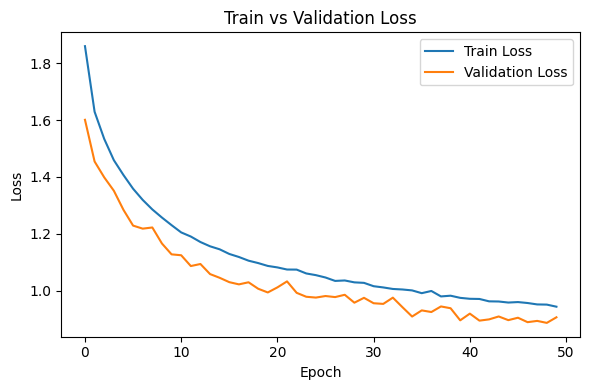

In [6]:
plt.figure(figsize=(6, 4))
plt.plot(train_loss_per_epoch, label="Train Loss")
plt.plot(val_loss_per_epoch, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# 在给定数据集上计算分类准确率


def evaluate(loader, model, device):
    """在给定数据加载器上评估分类准确率"""
    model.eval()  # 评估模式（关闭dropout等）
    correct = 0
    total = 0

    with torch.no_grad():  # 不记录梯度，节省显存
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)  # [B, num_classes]
            _, predicted = torch.max(outputs, 1)  # 取每行最大值的索引作为预测类别

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100.0 * correct / total
    return acc


train_acc = evaluate(trainloader, model, device)
test_acc = evaluate(testloader, model, device)

print(f"Train Accuracy: {train_acc:.2f}%")
print(f"Test  Accuracy: {test_acc:.2f}%")

Train Accuracy: 66.26%
Test  Accuracy: 67.84%
